In [1]:
import numpy as np
import pandas as pd
import random
import tqdm
import os
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from statistics import mode
from sklearn.metrics import accuracy_score
import operator
import pickle

In [ ]:
def calculate_phi(df, user1, user2, userList):
    n11 = 0
    n02 = 0
    n20 = 0
    n_1 = 0
    n1_ = 0
    index1 = userList.index(user1)
    index2 = userList.index(user2)
    for row in df.itertuples(index=False):
        if row[index1] == 1 and row[index2] == 1:
            n11 += 1
        if row[index1] == 0 and row[index2] == 2:
            n02 += 1
        if row[index1] == 2 and row[index2] == 0:
            n20 += 1
        if row[index1] == 1:
            n1_ += 1
        if row[index2] == 1:
            n_1 += 1
    if n1_ != 0:
        phi = (2*n11-4*(n02+n20)-n_1+n1_)/(4*n1_)
    else:
        phi = -999
    return phi, n1_

def select_threshold(dis, alpha):
    thresholds = []
    for k in range(dis.shape[0]):
        if k == 0:
            thresholds.append([np.quantile(dis[k],alpha),0.5, np.mean(dis[k])])
        else:
            thresholds.append([np.quantile(dis[k],alpha),np.quantile(dis[k],1-alpha), np.mean(dis[k])])
    return thresholds


def calculate_coef(df, ids):
    """
    return dict coef{(useri, userj):coef} 

    """
    userList = list(df.columns)
    phis_ = {}
    for couple in ids.values:
        
        phi_val_left = calculate_phi(df, str(couple[0]), str(couple[1]), userList)
        phi_val_right = calculate_phi(df, str(couple[1]), str(couple[0]), userList)
        phi_val = max(phi_val_left[0], phi_val_right[0]) # keeping the largest \phi

        phis_[(couple[0],couple[1])] = phi_val
        
    
    return phis_

def randomized_response(val, p, q):
    rand_val = np.random.uniform(0, 1)
    new_val = val
    if rand_val > p:
        if val == 0:
            new_val = 1
        elif val == 2:
            new_val = 1
        elif val == 1:
            if rand_val > p+q:
                new_val = 0
            else:
                new_val = 2
    return new_val

In [ ]:
def appCoef(ref_list, real_list, df_real, df_ref, K, eps, output_dir, seed, eps_flag = False):
    T = len(df_real)//K
    print(T)
    real = df_real.copy()
    ref = df_ref.copy()
    
    labels = {}
    if not os.path.isdir(output_dir+str(K)):
        os.makedirs(output_dir+str(K))
         
    for i_iter in range(T):
        if not eps_flag:
            copy_real = real.sample(int(K*(i_iter+1)), random_state = seed)
            copy_ref  = ref.sample(int(K*(i_iter+1)), random_state = seed)
            
        else: # introduce LDP to the testing set (true SNPs)
            p = np.exp(eps)/(np.exp(eps)+2)
            q = 1/(np.exp(eps)+2)
            
            copy_real = real.sample(int(K*(i_iter+1)), random_state = seed)
            copy_ref  = ref.sample(int(K*(i_iter+1)), random_state = seed)
            
            user_id_real = copy_real.columns
            user_id_ref = copy_ref.columns 
            
            for j in range(len(user_id_real)):
                copy_real[str(user_id_real[j])] = copy_real.apply(lambda x: randomized_response(x[str(user_id_real[j])], 
                                                                                           p, q), axis=1)
            for j in range(len(user_id_ref)):
                copy_ref[str(user_id_ref[j])] = copy_ref.apply(lambda x: randomized_response(x[str(user_id_ref[j])], 
                                                                                          p, q), axis=1)
        
        #real = real.drop(copy_real.index)
        #ref = ref.drop(copy_ref.index)

        # first, compute the coefficients on training set and obtain the thresholds
        dis = []
        for order, ids in enumerate(ref_list):
            coef_ref = calculate_coef(copy_ref, ids)
            dis.append(list(coef_ref.values()))
            
        threshold = select_threshold(np.array(dis), 0)
        if not eps_flag:
            np.savetxt(output_dir+str(K)+'/threshoulds' + str(i_iter) + '.txt', threshold)
        else:
            np.savetxt(output_dir+str(K)+'/threshoulds' + str(i_iter) + '_wiht_noise.txt', threshold)
        # then, compute the coefficients on testing set and do the classification
        for order, ids in enumerate(real_list):      
            coef_real = calculate_coef(copy_real, ids)
            
            for i, couple in enumerate(ids.values):
                if (couple[0],couple[1]) in labels:
                    labels[(couple[0],couple[1])].append(coef_real[(couple[0],couple[1])])
                else:
                    labels[(couple[0],couple[1])]=[coef_real[(couple[0],couple[1])]]
    if not eps_flag:
        with open(output_dir+str(K)+'/results.pkl', 'wb') as f:
            pickle.dump(labels,f)
    else:
        with open(output_dir+str(K)+'/results_with_noise.pkl', 'wb') as f:
            pickle.dump(labels,f)
                    

Firstly, recover the classification results based on the coefficients and thresholds<br>
Considered methods:
>A: Increment<br>
>B: Increment+Sim<br>
>C: Increment+Informative<br>
>D: Increment+Inform+Sim<br>
>E: Centralized (Using all 3000 SNPs)<br>
>AMIA(F: e = inf and G: e = 5) 

Then, include the details of the results in the tabel and graphs


# Four groups

In [ ]:
first_ref = pd.read_csv('../../reference/first_degree_ids.csv',sep = ",", index_col=0)
second_ref = pd.read_csv('../../reference/second_degree_ids.csv',sep = ",", index_col=0)
third_ref = pd.read_csv('../../reference/third_degree_ids.csv',sep = ",", index_col=0)
unrelated_ref = pd.read_csv('../../reference/unrelated_ids.csv',sep = ",", index_col=0)

first_degree = pd.read_csv('../../Kinship-main/Accuracy/Data/Relationships/first_degree_ids.csv',sep = ",", index_col=0)
second_degree = pd.read_csv('../../Kinship-main/Accuracy/Data/Relationships/second_degree_ids.csv',sep = ",", index_col=0)
third_degree = pd.read_csv('../../Kinship-main/Accuracy/Data/Relationships/third_degree_ids.csv',sep = ",", index_col=0)
unrelated_degree = pd.read_csv('../../Kinship-main/Accuracy/Data/Relationships/unrelated_ids.csv',sep = ",", index_col=0)

real_ids = [first_degree, second_degree,third_degree, unrelated_degree ]
ref_ids = [first_ref, second_ref,third_ref,unrelated_ref ]

df_real = pd.read_csv("../../Kinship-main/Accuracy/Data/Eye_color_relatives/mixture_with_all_relatives_3000_SNPs.csv", sep = ",", index_col=0)
df_ref = pd.read_csv('../../reference/mixture_with_all_relatives_3000_SNPs.csv',index_col=0)
df_ref = df_ref.reindex(df_real.index)

In [ ]:
seeds = np.random.randint(100, size = 10)
seeds 

In [ ]:
df_real = pd.read_csv("../../Kinship-main/Accuracy/Data/Eye_color_relatives/mixture_with_all_relatives_3000_SNPs.csv", sep = ",", index_col=0)
df_ref = pd.read_csv('../../reference/mixture_with_all_relatives_3000_SNPs.csv',index_col=0)
df_ref = df_ref.reindex(df_real.index)

## repeat the process for 10 times
seeds = [94, 82, 51, 46, 33, 19, 23, 74, 23, 84]

K_list = [100, 200, 400, 600, 800]
for itr, seed in enumerate(seeds):
    print(itr)
    for K in K_list[::-1]:
        appCoef(ref_ids,real_ids,df_real, df_ref, K, 5,'../../new_exp/' + str(itr) + '/evaluation/coefs/',seed)
 

In [462]:
def classification(thresholds, x, sim = True):
    #  classification based on simulated set
    if sim:
        res = []
        dis_to_center = []
        for k in range(len(thresholds)):
            if thresholds[k][0]< x and x < thresholds[k][1]:
                dis_to_center.append(np.abs(x-thresholds[k][2]))
                res.append(k+1)
        #print(res)
        if len(res)==0: # handle exceptions: for some batches, the coef of some un-related individuals are too small
            return 4
        # chose one label based on the ditance to the center
        return res[np.argmin(dis_to_center)]
    else:
        res = []
        for k in range(len(thresholds)):
            if k!=len(thresholds)-1:
                if x>=thresholds[k]:
                    res.append(k+1)
            else:
                if x<thresholds[k]:
                    res.append(k+1)
        #print(res)
        return np.min(res)


In [463]:
def fit_iter(in_dir, method, T, real_list, out_dir, sim = True, eps_flag = False):
    """
    Given the coefficients and thresholds at each iteration and algorithms
    Output the labels 
    """
    if not eps_flag:
        with open(in_dir+'results.pkl', 'rb') as f:
            coefs = pickle.load(f)
    else:
        with open(in_dir+'results_with_noise.pkl', 'rb') as f:
            coefs = pickle.load(f)
    
    labels = {}
    for i_iter in range(T):
        # thresholds based on the simulated set
        if sim:
            if eps_flag:
                threshold = np.loadtxt(in_dir + 'threshoulds' + str(i_iter)+'_with_noise.txt' )
            else:
                threshold = np.loadtxt(in_dir + 'threshoulds' + str(i_iter)+'.txt' )
        else: # thgreshold based on the predined values
            if len(real_list)==4:
                threshold = [0.175, 0.08, 0.025, 0.025]
            else:
                threshold = [0.025, 0.025]
                
        for order, ids in enumerate(real_list):
            
            for i, couple in enumerate(ids.values):
                if sim:
                    if (couple[0],couple[1]) in labels:
                        labels[(couple[0],couple[1])].append(classification(threshold, coefs[(couple[0],couple[1])][i_iter]))
                    else:
                        labels[(couple[0],couple[1])]=[classification(threshold, coefs[(couple[0],couple[1])][i_iter])]
                else:
                    if (couple[0],couple[1]) in labels:
                        labels[(couple[0],couple[1])].append(classification(threshold, coefs[(couple[0],couple[1])][i_iter], sim=False))
                    else:
                        labels[(couple[0],couple[1])]=[classification(threshold, coefs[(couple[0],couple[1])][i_iter], sim=False)]
        

    with open(out_dir + method + '_labels.pkl', 'wb') as f:
        pickle.dump(labels,f)


In [477]:
first_ref = pd.read_csv('../reference/first_degree_ids.csv',sep = ",", index_col=0)
second_ref = pd.read_csv('../reference/second_degree_ids.csv',sep = ",", index_col=0)
third_ref = pd.read_csv('../reference/third_degree_ids.csv',sep = ",", index_col=0)
unrelated_ref = pd.read_csv('../reference/unrelated_ids.csv',sep = ",", index_col=0)

first_degree = pd.read_csv('../Kinship-main/Accuracy/Data/Relationships/first_degree_ids.csv',sep = ",", index_col=0)
second_degree = pd.read_csv('../Kinship-main/Accuracy/Data/Relationships/second_degree_ids.csv',sep = ",", index_col=0)
third_degree = pd.read_csv('../Kinship-main/Accuracy/Data/Relationships/third_degree_ids.csv',sep = ",", index_col=0)
unrelated_degree = pd.read_csv('../Kinship-main/Accuracy/Data/Relationships/unrelated_ids.csv',sep = ",", index_col=0)

real_ids = [first_degree, second_degree,third_degree, unrelated_degree ]
ref_ids = [first_ref, second_ref,third_ref,unrelated_ref ]


In [84]:
for i in range(10): 
    for K in [100, 200, 400, 600, 800]: 
        in_dir = './' + str(i) + '/evaluation/coefs/' + str(K) + '/'
        out_dir = './' + str(i) + '/evaluation/coefs/' + str(K) + '/res/'

        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)

        method = 'B'
        T = int(3000/K)
        fit_iter(in_dir, 'B', T, real_ids, out_dir)

In [87]:
for i in range(10): 
    for K in [100, 200, 400, 600, 800]: 
        in_dir = './' + str(i) + '/evaluation/coefs/' + str(K) + '/'
        out_dir = './' + str(i) + '/evaluation/coefs/' + str(K) + '/res/'
        
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)

        method = 'A'
        T = int(3000/K)
        fit_iter(in_dir, 'A', T, real_ids, out_dir, sim=False)

In [88]:
for i in range(10): 
    for K in [100, 200, 400, 600, 800]: 
        in_dir = './' + str(i) + '/evaluation/coefs/' + str(K) + '/'
        out_dir = './' + str(i) + '/evaluation/coefs/' + str(K) + '/res/'

        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)

        method = 'G'
        T = int(3000/K)
        fit_iter(in_dir, 'G', T, real_ids, out_dir, sim=False, eps_flag=True)

In [465]:
def fit(in_dir, method, weight, out_dir):
    """
    Given the labels at each iteration
    Calculate the final prediciton with different methods, such as, 'majority', 'weighted_average','recent'
    
    return the final predictions for each pair of individuals
    """
    with open(in_dir, 'rb') as f:
        labels = pickle.load(f)
    
    T = len(list(labels.items())[0][1])
    final_res = []

    if weight == 'majority':
        for i_iter in range(T):
            res = [mode(list(labels.values())[i][:(i_iter+1)]) for i in range(len(labels.values()))]
            final_res.append(res)
    elif weight == 'recent':
        for i_iter in range(T):
            res = [list(labels.values())[i][i_iter] for i in range(len(labels.values()))]
            final_res.append(res)
    else:
        for i_iter in range(T):
            w = [1/(1+n) for n in range(i_iter+1)][::-1]
            wg = [k/np.sum(w) for k in w]
            res = [np.argmax(np.bincount(list(labels.values())[i][:(i_iter+1)], weights = wg)) for i in range(len(labels.values()))]
            final_res.append(res)
    
    np.savetxt(out_dir +'predictions.txt',np.array(final_res))
    
    return final_res

In [119]:
methods = ['A','B', 'F', 'G']
for i in range(10): 
    for K in [100, 200, 400, 600, 800]: 
        for method in methods:
            if method == 'F':
                in_dir =  './' + str(i) + '/evaluation/coefs/' + str(K) + '/res/'  + 'A_labels.pkl'
            else:
                in_dir =  './' + str(i) + '/evaluation/coefs/' + str(K) + '/res/' + method + '_labels.pkl'
                
            out_dir = './' + str(i) + '/evaluation/coefs/' + str(K) + '/res/' + method +'_'
        
            if method =='A' or method == 'B':
                fit(in_dir, method,  'weighted', out_dir)
            else:
                fit(in_dir,method,  'recent', out_dir)

In [130]:
def acc_scores(methods,labels, in_dir, K_list, y_true):
    true_bi = label_binarize(y_true, classes=[1, 2, 3,4])
    
    for K in K_list:
        print(K)
        T = 3000//K
        acc_first = {}
        acc_second = {}
        acc_third = {}
        acc_non = {}
        acc_all = {}
        
        path_dir = in_dir + str(K) + '/res/'
        
        for index, method in enumerate(methods):
            if labels[index]== 'Increment+Informative': # import C
                pred = np.loadtxt('../incrimental/evaluation2/approachC/'+ str(K) + '/predictions.txt')
            elif labels[index]== 'Increment+Inform+Sim': # import D
                pred = np.loadtxt('../incrimental/evaluation2/approachA/'+ str(K) + '/predictions.txt')
            else:
                pred = np.loadtxt(path_dir  + method + '_predictions.txt')

            for i_iter in range(T):
                if labels[index] in acc_first:
                    acc_first[labels[index]].append(accuracy_score(y_true[:200],pred[i_iter,:200]))
                else:
                    acc_first[labels[index]] = [accuracy_score(y_true[:200],pred[i_iter,:200])]

                if labels[index] in acc_second:
                    acc_second[labels[index]].append(accuracy_score(y_true[200:400],pred[i_iter,200:400]))
                else:
                    acc_second[labels[index]] = [accuracy_score(y_true[200:400],pred[i_iter,200:400])]

                if labels[index] in acc_third:
                    acc_third[labels[index]].append(accuracy_score(y_true[400:600],pred[i_iter,400:600]))
                else:
                    acc_third[labels[index]] = [accuracy_score(y_true[400:600],pred[i_iter,400:600])]

                if labels[index] in acc_non:
                    acc_non[labels[index]].append(accuracy_score(y_true[600:],pred[i_iter,600:]))
                else:
                    acc_non[labels[index]] = [accuracy_score(y_true[600:],pred[i_iter,600:])]
                    
                if labels[index] in acc_all:
                    acc_all[labels[index]].append(accuracy_score(y_true,pred[i_iter]))
                else:
                    acc_all[labels[index]] = [accuracy_score(y_true,pred[i_iter])]

        with open(path_dir + '1_acc_scores.pkl', 'wb') as f:
            pickle.dump(acc_first, f)
        
        with open(path_dir +'2_acc_scores.pkl', 'wb') as f:
            pickle.dump(acc_second, f)
        
        with open(path_dir +'3_acc_scores.pkl', 'wb') as f:
            pickle.dump(acc_third, f)
        
        with open(path_dir +'non_acc_scores.pkl','wb') as f:
            pickle.dump(acc_non,f)
        
        with open(path_dir + 'acc_scores.pkl', 'wb') as f:
            pickle.dump(acc_all,f)
     

In [504]:
def auc_scores(methods,labels, in_dir, K_list, y_true):
    true_bi = label_binarize(y_true, classes=[1, 2, 3,4])
    
    for K in K_list:
        T = 3000//K
        auc_first = {}
        auc_second = {}
        auc_third = {}
        auc_non = {}
        auc_all = {}
        path_dir = in_dir + str(K) + '/res/'
        
        for index, method in enumerate(methods):
            if labels[index]== 'Increment+Informative': # import C
                pred = np.loadtxt('../incrimental/evaluation2/approachC/'+ str(K) + '/predictions.txt')
            elif labels[index]== 'Increment+Inform+Sim': # import D
                pred = np.loadtxt('../incrimental/evaluation2/approachA/'+ str(K) + '/predictions.txt')
            else:
                pred = np.loadtxt(path_dir  + method + '_predictions.txt')

            for i_iter in range(T):
                pred_bi = label_binarize(pred[i_iter,:], classes=[1, 2, 3,4])

                fpr = dict()
                tpr = dict()
                roc_auc = dict()


                for i in range(4):
                    fpr[i], tpr[i], _ = roc_curve(true_bi[:, i], pred_bi[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])

                if labels[index] in auc_first:
                    auc_first[labels[index]].append(roc_auc[0])
                else:
                    auc_first[labels[index]] = [roc_auc[0]]

                if labels[index] in auc_second:
                    auc_second[labels[index]].append(roc_auc[1])
                else:
                    auc_second[labels[index]] = [roc_auc[1]]

                if labels[index] in auc_third:
                    auc_third[labels[index]].append(roc_auc[2])
                else:
                    auc_third[labels[index]] = [roc_auc[2]]

                if labels[index] in auc_non:
                    auc_non[labels[index]].append(roc_auc[3])
                else:                                                                                                                                                                                                                                                            
                    auc_non[labels[index]] = [roc_auc[3]]
                
                if labels[index] in auc_all:
                    auc_all[labels[index]].append(roc_auc_score(pred_bi,true_bi,average='weighted', multi_class='ovo'))
                else:
                    auc_all[labels[index]] = [roc_auc_score(pred_bi,true_bi,average='weighted', multi_class = 'ovo')]
        
        # save the scores of each method for each group
        with open(path_dir +'1_auc_scores.pkl', 'wb') as f:
            pickle.dump(auc_first, f)
        
        with open(path_dir +'2_auc_scores.pkl', 'wb') as f:
            pickle.dump(auc_second, f)
        
        with open(path_dir +'3_auc_scores.pkl', 'wb') as f:
            pickle.dump(auc_third, f)
        
        with open(path_dir +'non_auc_scores.pkl','wb') as f:
            pickle.dump(auc_non,f)
        
        with open(path_dir +'auc_scores.pkl', 'wb') as f:
            pickle.dump(auc_all,f)
     

In [505]:
first_ = pd.read_csv('../stopping/Accuracy/'+str(100)+'/first_relatives.csv')
second_= pd.read_csv('../stopping/Accuracy/'+str(100)+'/second_relatives.csv')
third_ = pd.read_csv('../stopping/Accuracy/'+str(100)+'/third_relatives.csv')
non_ = pd.read_csv('../stopping/Accuracy/'+str(100)+'/unrelated.csv')

df_real = pd.read_csv("../Kinship-main/Accuracy/Data/Eye_color_relatives/mixture_with_all_relatives_3000_SNPs.csv", sep = ",", index_col=0)
df_ref = pd.read_csv('../reference/mixture_with_all_relatives_3000_SNPs.csv',index_col=0)
df_ref = df_ref.reindex(df_real.index)

all_results = pd.concat([first_,second_,third_,non_],axis=0)
all_results = all_results.drop('coef',axis=1)
y_true = np.array(all_results['label'])

In [506]:
for i in range(10):
    in_dir =  './' + str(i) + '/evaluation/coefs/'
    K_list = [100, 200, 400, 600]
    methods = ['A', 'B', 'C', 'D', 'F', 'G' ]
    labels = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'AMIA', 'AMIA(eps = 5)']
    auc_scores(methods,labels, in_dir, K_list, y_true)

In [132]:
for i in range(10):
    in_dir =  './' + str(i) + '/evaluation/coefs/'
    K_list = [100, 200, 400, 600, 800]
    methods = ['A', 'B', 'C', 'D', 'F', 'G' ]
    labels = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'AMIA', 'AMIA(eps = 5)']
    acc_scores(methods,labels, in_dir, K_list, y_true)

100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800


In [133]:
with open( './' + str(0) + '/evaluation/coefs/100/res/acc_scores.pkl', 'rb') as f:
    coefs = pickle.load(f)

In [134]:
coefs

{'Increment': [0.5414285714285715,
  0.6071428571428571,
  0.6457142857142857,
  0.6771428571428572,
  0.6828571428571428,
  0.71,
  0.7214285714285714,
  0.7371428571428571,
  0.7528571428571429,
  0.7657142857142857,
  0.7671428571428571,
  0.7757142857142857,
  0.7742857142857142,
  0.7771428571428571,
  0.7885714285714286,
  0.79,
  0.7971428571428572,
  0.7985714285714286,
  0.8,
  0.7985714285714286,
  0.8057142857142857,
  0.8057142857142857,
  0.8057142857142857,
  0.8071428571428572,
  0.8028571428571428,
  0.8057142857142857,
  0.8057142857142857,
  0.8042857142857143,
  0.8042857142857143,
  0.8028571428571428],
 'Increment+Sim': [0.5371428571428571,
  0.6257142857142857,
  0.6585714285714286,
  0.6871428571428572,
  0.6942857142857143,
  0.7228571428571429,
  0.7514285714285714,
  0.7614285714285715,
  0.7557142857142857,
  0.7757142857142857,
  0.7814285714285715,
  0.7942857142857143,
  0.7942857142857143,
  0.8014285714285714,
  0.7971428571428572,
  0.8057142857142857,


# binary case

In [489]:
first_ref = pd.read_csv('../reference/first_degree_ids.csv',sep = ",", index_col=0)
second_ref = pd.read_csv('../reference/second_degree_ids.csv',sep = ",", index_col=0)
third_ref = pd.read_csv('../reference/third_degree_ids.csv',sep = ",", index_col=0)
unrelated_ref = pd.read_csv('../reference/unrelated_ids.csv',sep = ",", index_col=0)

first_degree = pd.read_csv('../Kinship-main/Accuracy/Data/Relationships/first_degree_ids.csv',sep = ",", index_col=0)
second_degree = pd.read_csv('../Kinship-main/Accuracy/Data/Relationships/second_degree_ids.csv',sep = ",", index_col=0)
third_degree = pd.read_csv('../Kinship-main/Accuracy/Data/Relationships/third_degree_ids.csv',sep = ",", index_col=0)
unrelated_degree = pd.read_csv('../Kinship-main/Accuracy/Data/Relationships/unrelated_ids.csv',sep = ",", index_col=0)

relatives_ref = pd.concat([first_ref,second_ref,third_ref])
relatives = pd.concat([first_degree,second_degree,third_degree])

In [149]:
for i in range(10): 
    for K in [100, 200, 400, 600, 800]: 
        in_dir = './' + str(i) + '/binary/evaluation/coefs/' + str(K) + '/'
        out_dir = './' + str(i) + '/binary/evaluation/coefs/' + str(K) + '/res/'

        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)

        method = 'B'
        T = int(3000/K)
        fit_iter(in_dir, 'B', T, [relatives, unrelated_degree], out_dir)

In [150]:
for i in range(10): 
    for K in [100, 200, 400, 600, 800]: 
        in_dir = './' + str(i) + '/binary/evaluation/coefs/' + str(K) + '/'
        out_dir = './' + str(i) + '/binary/evaluation/coefs/' + str(K) + '/res/'
        
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)

        method = 'A'
        T = int(3000/K)
        fit_iter(in_dir, 'A', T, [relatives, unrelated_degree], out_dir, sim=False)

In [151]:
for i in range(10): 
    for K in [100, 200, 400, 600, 800]: 
        in_dir = './' + str(i) + '/binary/evaluation/coefs/' + str(K) + '/'
        out_dir = './' + str(i) + '/binary/evaluation/coefs/' + str(K) + '/res/'

        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)

        method = 'G'
        T = int(3000/K)
        fit_iter(in_dir, 'G', T, [relatives, unrelated_degree], out_dir, sim=False, eps_flag=True)

In [152]:
methods = ['A','B', 'F', 'G']
for i in range(10): 
    for K in [100, 200, 400, 600, 800]: 
        for method in methods:
            if method == 'F':
                in_dir =  './' + str(i) + '/binary/evaluation/coefs/' + str(K) + '/res/'  + 'A_labels.pkl'
            else:
                in_dir =  './' + str(i) + '/binary/evaluation/coefs/' + str(K) + '/res/' + method + '_labels.pkl'
                
            out_dir = './' + str(i) + '/binary/evaluation/coefs/' + str(K) + '/res/' + method +'_'
        
            if method =='A' or method == 'B':
                fit(in_dir, method,  'weighted', out_dir)
            else:
                fit(in_dir,method,  'recent', out_dir)

In [157]:
def acc_scores_binary(methods,labels, in_dir, K_list, y_true):
    
    for K in K_list:
        T = 3000//K
        acc_rel = {}
        acc_non = {}
        acc_all = {}
        
        path_dir = in_dir + str(K) + '/res/'
        
        for index, method in enumerate(methods):
            if labels[index]== 'Increment+Informative': # import C
                pred = np.loadtxt('../incrimental/binary/evaluation2/approachC/'+ str(K) + '/predictions.txt')
            elif labels[index]== 'Increment+Inform+Sim': # import D
                pred = np.loadtxt('../incrimental/binary/evaluation2/approachA/'+ str(K) + '/predictions.txt')
            else:
                pred = np.loadtxt(path_dir  + method + '_predictions.txt')

            for i_iter in range(T):
                if labels[index] in acc_rel:
                    acc_rel[labels[index]].append(accuracy_score(y_true[:600],pred[i_iter,:600]))
                else:
                    acc_rel[labels[index]] = [accuracy_score(y_true[:600],pred[i_iter,:600])]

                if labels[index] in acc_non:
                    acc_non[labels[index]].append(accuracy_score(y_true[600:],pred[i_iter,600:]))
                else:
                    acc_non[labels[index]] = [accuracy_score(y_true[600:],pred[i_iter,600:])]
                    
                if labels[index] in acc_all:
                    acc_all[labels[index]].append(accuracy_score(y_true,pred[i_iter]))
                else:
                    acc_all[labels[index]] = [accuracy_score(y_true,pred[i_iter])]
        
        # save all the scores
        with open(path_dir + '1_acc_scores.pkl', 'wb') as f:
            pickle.dump(acc_rel, f)
            
        with open(path_dir + 'non_acc_scores.pkl', 'wb') as f:
            pickle.dump(acc_non, f)
            
        with open(path_dir + 'acc_scores.pkl', 'wb') as f:
            pickle.dump(acc_all, f)
     

In [503]:
def auc_scores_binary(methods,labels, in_dir, K_list, y_true):
    true_bi = label_binarize(y_true, classes=[1, 2, 3,4])
    
    for K in K_list:
        T = 3000//K
        auc_ = {}
        
        path_dir = in_dir + str(K) + '/res/'
        
        for index, method in enumerate(methods):
            if labels[index]== 'Increment+Informative': # import C
                pred = np.loadtxt('../incrimental/binary/evaluation2/approachC/'+ str(K) + '/predictions.txt')
            elif labels[index]== 'Increment+Inform+Sim': # import D
                pred = np.loadtxt('../incrimental/binary/evaluation2/approachA/'+ str(K) + '/predictions.txt')
            else:
                pred = np.loadtxt(path_dir  + method + '_predictions.txt')

            for i_iter in range(T):
                roc_auc = roc_auc_score(y_true, pred[i_iter],'weighted')
        
                if labels[index] in auc_:
                    auc_[labels[index]].append(roc_auc)
                else:
                    auc_[labels[index]] = [roc_auc]
        
        
        with open(path_dir+'auc_scores.pkl', 'wb') as f:
            pickle.dump(auc_, f)

     

In [494]:
rel_ = pd.read_csv('../stopping/Accuracy/'+str(0)+'/relatives.csv')
non_ = pd.read_csv('../stopping/Accuracy/'+str(0)+'/unrelated.csv')

all_results = pd.concat([rel_,non_],axis=0)
all_results = all_results.drop('coef',axis=1)

y_true = np.array(all_results['label'])

In [500]:
for i in range(10):
    in_dir =  './' + str(i) + '/binary/evaluation/coefs/'
    K_list = [100, 200, 400, 600, 800]
    methods = ['A', 'B', 'C', 'D', 'F', 'G' ]
    labels = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'AMIA', 'AMIA(eps = 5)']
    auc_scores_binary(methods,labels, in_dir, K_list, y_true)

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\amio\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an 

In [162]:
for i in range(10):
    in_dir =  './' + str(i) + '/binary/evaluation/coefs/'
    K_list = [100, 200, 400, 600, 800]
    methods = ['A', 'B', 'C', 'D', 'F', 'G' ]
    labels = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'AMIA', 'AMIA(eps = 5)']
    acc_scores_binary(methods,labels, in_dir, K_list, y_true)

100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800
100
200
400
600
800


In [166]:
with open( './' + str(0) + '/binary/evaluation/coefs/100/res/auc_scores.pkl', 'rb') as f:
    coefs = pickle.load(f)

In [167]:
coefs

{'Increment': [0.7108333333333333,
  0.7216666666666667,
  0.7591666666666668,
  0.7725,
  0.78,
  0.7908333333333333,
  0.7825,
  0.8033333333333332,
  0.8049999999999999,
  0.8049999999999999,
  0.8116666666666666,
  0.835,
  0.8258333333333333,
  0.8308333333333333,
  0.8325000000000001,
  0.8366666666666667,
  0.8508333333333333,
  0.8449999999999999,
  0.85,
  0.8541666666666667,
  0.8608333333333333,
  0.8591666666666667,
  0.8591666666666667,
  0.8608333333333333,
  0.8591666666666667,
  0.8666666666666667,
  0.865,
  0.8725000000000002,
  0.87,
  0.8691666666666666],
 'Increment+Sim': [0.7166666666666667,
  0.7558333333333334,
  0.7906666666666666,
  0.7933333333333332,
  0.818725,
  0.8211999999999999,
  0.8228499999999999,
  0.8375,
  0.8225,
  0.8366666666666666,
  0.8374999999999999,
  0.8374999999999999,
  0.8350000000000001,
  0.8308333333333333,
  0.8416666666666667,
  0.8391666666666666,
  0.8433333333333334,
  0.8483333333333333,
  0.8516666666666667,
  0.8500000000000

# Tabels and Graphs

## Four groups

In [515]:
K_list = [100, 200, 400, 600]
methods = ['A','B','C', 'D',  'F', 'G']
labels = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'AMIA', 'AMIA(eps = 5)']

rs = []
cc = []
for K in K_list:
    print(K)
    best_res = pd.DataFrame()
    best_cct = pd.DataFrame()
    for i in range(10):
        f = open('./' + str(i) + '/evaluation/coefs/' + str(K) + '/res/auc_scores.pkl', 'rb')
        acc_all = pickle.load(f)
        f.close()
        res = {}
        count = {}
        for index, (label, method) in enumerate(zip(labels, methods)):
         #  # if method == 'F' or method == 'G':
            idx = -1
         #   else:
            #idx = np.argmax(acc_all[label])
            #print(idx, acc_all[label][idx])
            res[label] = [acc_all[label][idx]]
            count[label] = [(idx+1)*K]
        best_cct = pd.concat([best_cct, pd.DataFrame(count)])   
        best_res = pd.concat([best_res, pd.DataFrame(res)])
    
    rs.append(list(best_res.mean()))
    cc.append(list(best_cct.mean()))
    #print(pd.DataFrame(best_res))

100
200
400
600


In [261]:
best_res.mean()

Increment                0.869442
Increment+Sim            0.879220
Increment+Informative    0.861837
Increment+Inform+Sim     0.869945
AMIA                     0.872683
AMIA(eps = 5)            0.867451
dtype: float64

In [449]:
acc_all

{'Increment': [0.505980612461177,
  0.5029279304501034,
  0.5039690663881411,
  0.5031847605198685,
  0.5029806963784276],
 'Increment+Sim': [0.5040382878993319,
  0.5017056991071677,
  0.5028726174873802,
  0.5027278775781769,
  0.5021603511725073],
 'Increment+Informative': [0.5180266430081958,
  0.5139797240278998,
  0.5059574697263431,
  0.5048148365706341,
  0.5049102884347819],
 'Increment+Inform+Sim': [0.5142606737807447,
  0.5103736961657968,
  0.5068226543562371,
  0.5030909375368757,
  0.5033455056879996],
 'AMIA': [0.505980612461177,
  0.5029279304501034,
  0.5039690663881411,
  0.5028467034766653,
  0.5023094811048907],
 'AMIA(eps = 5)': [0.5067321581614357,
  0.5027342187867073,
  0.5043238061353574,
  0.5025513139772021,
  0.5028409545461818]}

In [516]:
np.array(rs).transpose()

array([[0.87008853, 0.8699069 , 0.86725049, 0.86944198],
       [0.88052004, 0.88061606, 0.87699238, 0.87921973],
       [0.86863312, 0.86351086, 0.86041798, 0.8618369 ],
       [0.87706447, 0.87558207, 0.86937106, 0.86994494],
       [0.87268336, 0.87268336, 0.87031163, 0.87268336],
       [0.86648688, 0.86776967, 0.86524012, 0.86745084]])

In [228]:
np.array(cc).transpose()

array([[2750., 2880., 2560., 3000., 2400.],
       [2850., 2820., 2640., 3000., 2400.],
       [3000., 3000., 2800., 3000., 2400.],
       [3000., 3000., 2800., 3000., 2400.],
       [2710., 2740., 2520., 2820., 2400.],
       [2640., 2840., 2640., 2880., 2320.]])

In [439]:
best_res.transpose()

,0,0,0,0,0,0,0,0,0,0
Increment,0.502425,0.503443,0.505244,0.501010,0.502028,0.501624,0.501624,0.501010,0.501624,0.502444
Increment+Sim,0.500010,0.501679,0.501888,0.499171,0.499812,0.500220,0.499183,0.500628,0.499183,0.499592
Increment+Informative,0.505287,0.505287,0.505287,0.505287,0.505287,0.505287,0.505287,0.505287,0.505287,0.505287
Increment+Inform+Sim,0.500224,0.500224,0.500224,0.500224,0.500224,0.500224,0.500224,0.500224,0.500224,0.500224
AMIA,0.502026,0.502026,0.502026,0.502026,0.502026,0.502026,0.502026,0.502026,0.502026,0.502026
AMIA(eps = 5),0.503409,0.503194,0.502402,0.502615,0.503034,0.502414,0.502181,0.503614,0.504573,0.503788


In [517]:
K_list = [100, 200, 400, 600]
methods = ['A','B','C', 'D',  'F', 'G']
labels = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'AMIA', 'AMIA(eps = 5)']

cc = []
for K in K_list:
    print(K)
    best_res = pd.DataFrame()
    best_cct = pd.DataFrame()
    for i in range(10):
        f = open('./' + str(i) + '/evaluation/coefs/' + str(K) + '/res/auc_scores.pkl', 'rb')
        acc_all = pickle.load(f)
        f.close()
        count = {}
        base = acc_all['AMIA'][-1]
        for index, (label, method) in enumerate(zip(labels, methods)):
            
            if np.max(acc_all[label])>base:
                idx = np.argmax(acc_all[label]>base)
            else:
                idx = len(acc_all[label])+1
            count[label] = [(idx+1)*K]
        best_cct = pd.concat([best_cct, pd.DataFrame(count)])   
    
    cc.append(list(best_cct.mean()))
    #print(pd.DataFrame(best_res))

100
200
400
600


In [296]:
acc_all

{'Increment': [0.7178763473517742,
  0.7556364699600062,
  0.7732903702830938,
  0.7993501029215315,
  0.811589863381193,
  0.8167628914421039,
  0.819898849368954,
  0.8044370486929144,
  0.8075675779818451,
  0.8171759892011274,
  0.8205475123054032,
  0.8253837822614755,
  0.8305903281621492,
  0.832111003529233,
  0.8386561548095594,
  0.8434862372826577,
  0.8441802709779287,
  0.8452654919716356,
  0.8481395243426776,
  0.8509029581820908,
  0.8515710817009988,
  0.8590103897873432,
  0.8597518704675485,
  0.8581480863762398,
  0.8569000904155328,
  0.8576332300088411,
  0.8627806262013004,
  0.8656149959983994,
  0.8692785013389849,
  0.8698333194943635],
 'Increment+Sim': [0.7228581819504424,
  0.755112065999635,
  0.776567212500663,
  0.7980826691353008,
  0.8129791628964225,
  0.8136178087832122,
  0.8200660610654931,
  0.805277065682208,
  0.8176727309411157,
  0.8229975154866143,
  0.8300841434647886,
  0.835909945971923,
  0.8348060602081768,
  0.8421267127685764,
  0.8419

In [289]:
acc_all

{'Increment': [0.8132509971404319,
  0.8329976209507148,
  0.851237403522112,
  0.8525369061276121,
  0.8688044455639624],
 'Increment+Sim': [0.806495750006707,
  0.8435667992843654,
  0.8580837718395689,
  0.8686576619781384,
  0.8797493269519178],
 'Increment+Informative': [0.7666866919682804,
  0.7937630084006279,
  0.8245367847774081,
  0.8447988140338903,
  0.8618368996691252],
 'Increment+Inform+Sim': [0.7776326483223035,
  0.8136732725026253,
  0.8336715098975749,
  0.8623837804752371,
  0.8699449443142502],
 'AMIA': [0.8132509971404319,
  0.8329976209507148,
  0.851237403522112,
  0.8636302006499679,
  0.8726833561328335],
 'AMIA(eps = 5)': [0.805304305370395,
  0.8261701292299176,
  0.8448321410575209,
  0.8615711232451195,
  0.8664386769318744]}

In [290]:
best_cct

,Increment,Increment+Sim,Increment+Informative,Increment+Inform+Sim,AMIA,AMIA(eps = 5)
0,4200,1800,4200,4200,4200,4200
0,3000,2400,4200,4200,2400,4200
0,4200,3000,4200,4200,4200,4200
0,3000,2400,4200,4200,4200,4200
0,4200,3000,4200,4200,4200,4200
0,4200,3000,4200,4200,4200,4200
0,4200,2400,4200,4200,2400,4200
0,4200,3000,4200,4200,4200,4200
0,4200,2400,4200,4200,2400,4200
0,4200,3000,4200,4200,4200,4200


In [201]:
best_cct

,Increment,Increment+Sim,Increment+Informative,Increment+Inform+Sim,AMIA,AMIA(eps = 5)
0,2400,2400,2400,2400,2400,1600
0,2400,2400,2400,2400,2400,2400
0,2400,2400,2400,2400,2400,2400
0,2400,2400,2400,2400,2400,2400
0,2400,2400,2400,2400,2400,2400
0,2400,2400,2400,2400,2400,2400
0,2400,2400,2400,2400,2400,2400
0,2400,2400,2400,2400,2400,2400
0,2400,2400,2400,2400,2400,2400
0,2400,2400,2400,2400,2400,2400


In [518]:
np.array(cc).transpose()

array([[3080., 3180., 3240., 3960.],
       [2280., 2360., 2440., 2640.],
       [3200., 3400., 3600., 4200.],
       [3000., 3000., 3280., 4200.],
       [2740., 2920., 2760., 3660.],
       [3100., 3140., 3320., 4200.]])

In [103]:
font = {'family' : 'Times New Roman',
        'size'   : 24}
plt.rc('font', **font)
markers = ['o', '', 'v', 'p', '1', '*', 's', 'p', 'h', '+', 'o', '+']
colors = ['#2a9d8f','#264653',  '#f4a261', '#7f5539', '#8ab17d', '#7f5539', '#f4a261', '#e76f51' , '#264653', '#7f5539', '#8f2d56', '#363073']


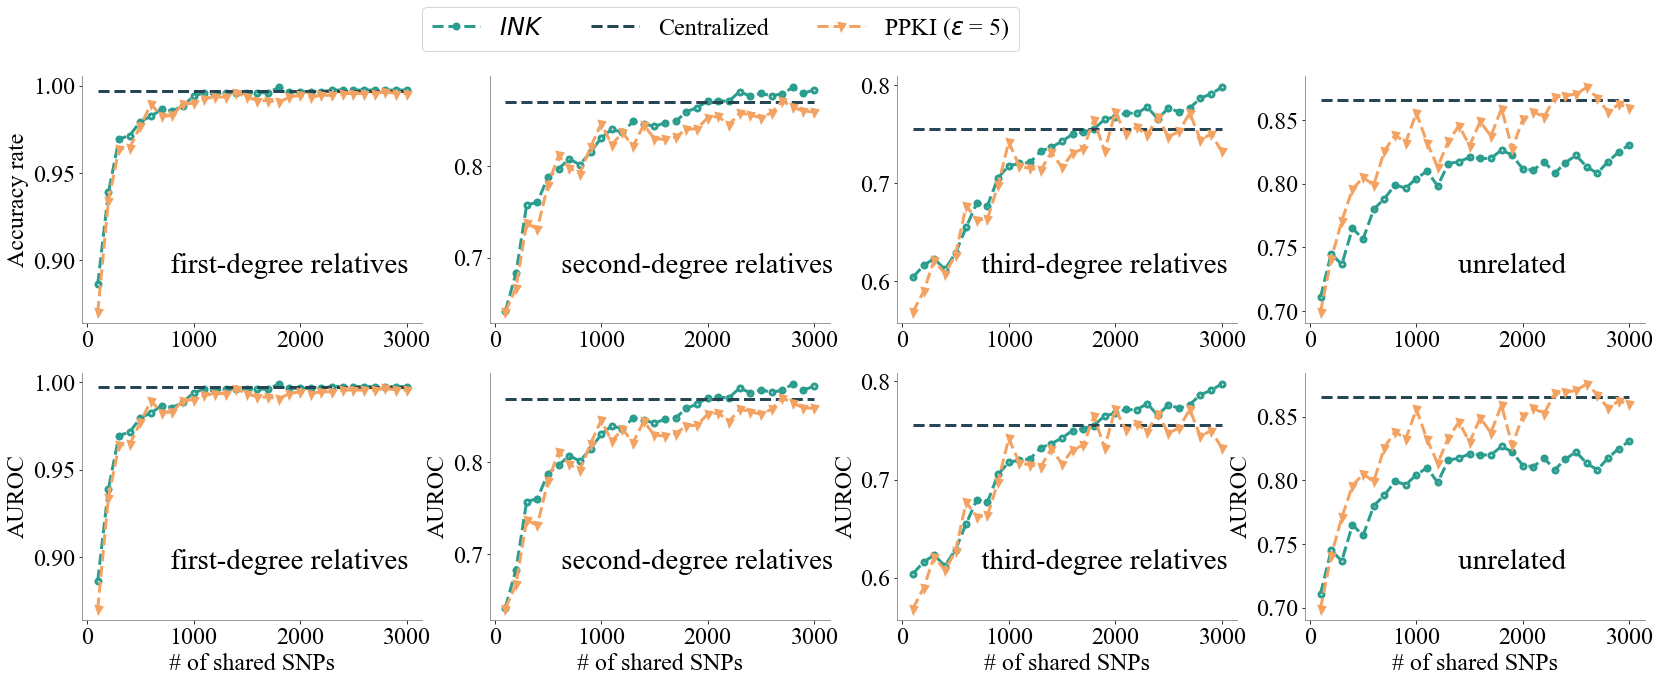

In [104]:
f1, axs1 = plt.subplots (2, 4, figsize=(28, 10))
axs1 = axs1.ravel()
K = 100
T = 3000//K
in_dir = './' + str(1) + '/evaluation/coefs/'


#methods = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'Centralized', 'AMIA(eps = 5)']
#labels = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'Centralized', r'PPKI ($\epsilon$ = 5)']

methods = ['Increment+Sim', 'Centralized','AMIA(eps = 5)']
labels = [r'$\it{INK}$','Centralized', r'PPKI ($\epsilon$ = 5)' ]

relationships = ['first-degree relatives', 'second-degree relatives','third-degree relatives','unrelated', 'all']

with open(in_dir+str(100)+'/res/1_acc_scores.pkl', 'rb') as f:
    auc_first = pickle.load(f)

with open(in_dir+str(100)+'/res/2_acc_scores.pkl', 'rb') as f:
    auc_second = pickle.load(f)

with open(in_dir+str(100)+'/res/3_acc_scores.pkl', 'rb') as f:
    auc_third = pickle.load(f)

with open(in_dir+str(100)+'/res/non_acc_scores.pkl','rb') as f:
    auc_non = pickle.load(f)

with open(in_dir+str(100)+'/res/1_auc_scores.pkl', 'rb') as f:
    auc_first = pickle.load(f)

with open(in_dir+str(100)+'/res/2_auc_scores.pkl', 'rb') as f:
    auc_second = pickle.load(f)

with open(in_dir+str(100)+'/res/3_auc_scores.pkl', 'rb') as f:
    auc_third = pickle.load(f)

with open(in_dir+str(100)+'/res/non_auc_scores.pkl','rb') as f:
    auc_non = pickle.load(f)
    
for i, auc_res in enumerate([auc_first, auc_second, auc_third,auc_non ]):

    auc_res['AMIA'] = [auc_res['AMIA'][-1] for _ in range(len(auc_res['AMIA']))]

    for index, (label, method) in enumerate(zip(labels, methods)):
        if label =='Centralized':
            auc_res[label] = auc_res['AMIA']
        axs1[i].plot([K*(i_iter+1) for i_iter in range(T)] , auc_res[method], lw=3,
                     marker = markers[index], markersize = 5, markeredgewidth=3, 
                     linestyle='--', color = colors[index],markerfacecolor="None",
                 label=label)
    
   # axs1[i].set_xlabel('# of shared SNPs')
    axs1[i].set_ylabel('Accuracy rate')
    if i > 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i].spines[spine].set_edgecolor('gray')
    axs1[i].set_title(' %s' %(relationships[i]),x = 0.6, y =0.18)

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
    if i==0:
        axs1[i].legend(loc=(1, 1.1),ncol=3)

for i, auc_res in enumerate([auc_first, auc_second, auc_third,auc_non ]):

    auc_res['AMIA'] = [auc_res['AMIA'][-1] for _ in range(len(auc_res['AMIA']))]

    for index, (label, method) in enumerate(zip(labels, methods)):
        if label =='Centralized':
            auc_res[label] = auc_res['AMIA']
        axs1[i+4].plot([K*(i_iter+1) for i_iter in range(T)] , auc_res[method], 
                     marker = markers[index], markersize = 5, markeredgewidth=3,lw=3,
                     linestyle='--', color = colors[index],markerfacecolor="None",
                 label=label)
    
    axs1[i+4].set_xlabel('# of shared SNPs')
    axs1[i+4].set_ylabel('AUROC')
    if i> 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i+4].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i+4].spines[spine].set_edgecolor('gray')
    axs1[i+4].set_title(' %s' %(relationships[i]),x = 0.6, y =0.18)

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
  #  if i==0:
   #     axs1[i].legend(loc=(-0.1, 1.1),ncol=6)
#plt.subplots_adjust(wspace=0.15,hspace=0.05)

#plt.subplots_adjust(wspace=0.15,hspace=0.05)
plt.savefig('./3.png', dpi= 400, bbox_inches = "tight")
plt.show()

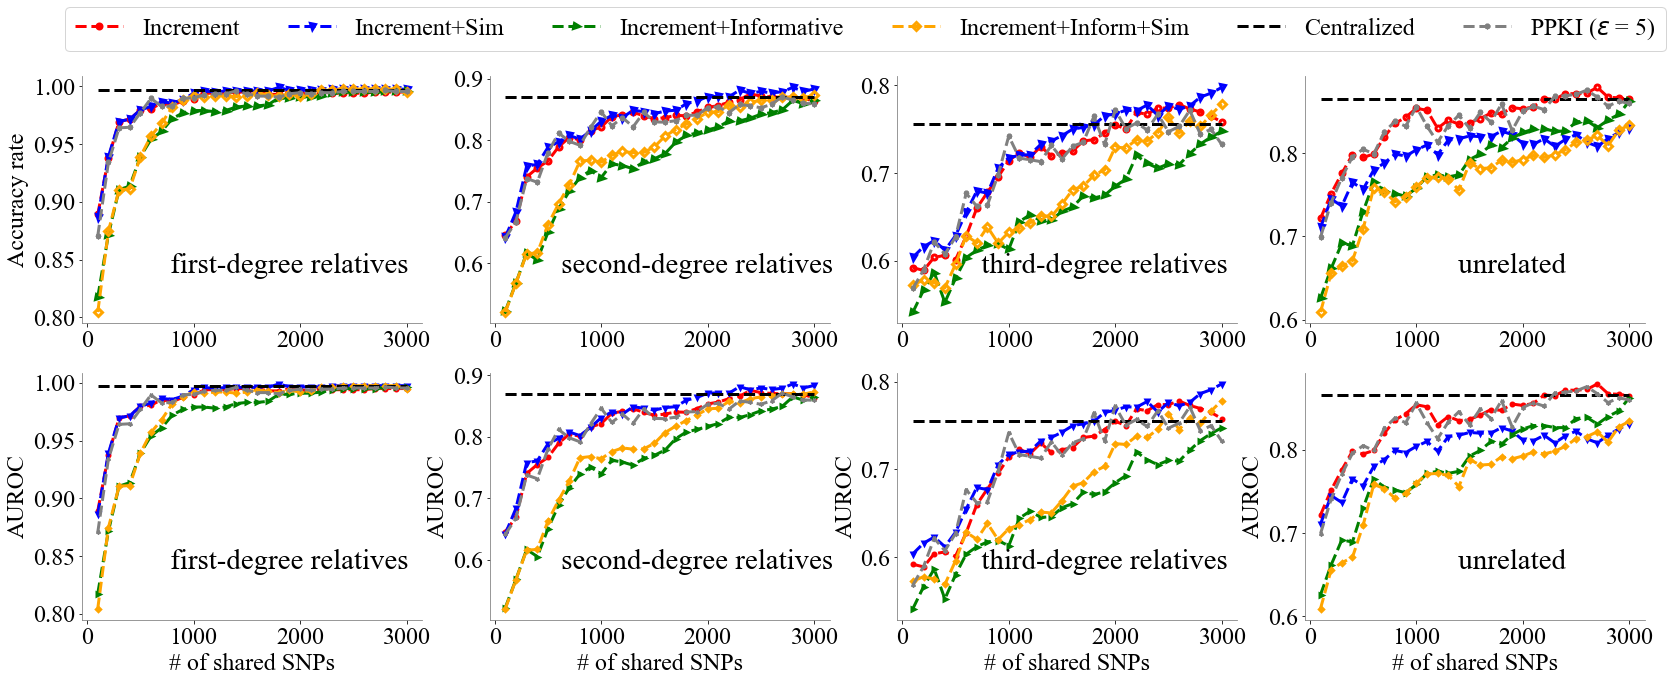

In [102]:
f1, axs1 = plt.subplots (2, 4, figsize=(28, 10))
axs1 = axs1.ravel()
K = 100
T = 3000//K
in_dir = './' + str(1) + '/evaluation/coefs/'

markers = ['o', 'v', '>', 'D', '', '*', 's', 'p', 'h', '+']
colors = ['red', 'blue', 'green', 'orange', 'black','gray']

methods = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'Centralized', 'AMIA(eps = 5)']
labels = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'Centralized', r'PPKI ($\epsilon$ = 5)']
relationships = ['first-degree relatives', 'second-degree relatives','third-degree relatives','unrelated', 'all']


with open(in_dir+str(100)+'/res/1_acc_scores.pkl', 'rb') as f:
    auc_first = pickle.load(f)

with open(in_dir+str(100)+'/res/2_acc_scores.pkl', 'rb') as f:
    auc_second = pickle.load(f)

with open(in_dir+str(100)+'/res/3_acc_scores.pkl', 'rb') as f:
    auc_third = pickle.load(f)

with open(in_dir+str(100)+'/res/non_acc_scores.pkl','rb') as f:
    auc_non = pickle.load(f)

with open(in_dir+str(100)+'/res/1_auc_scores.pkl', 'rb') as f:
    auc_first = pickle.load(f)

with open(in_dir+str(100)+'/res/2_auc_scores.pkl', 'rb') as f:
    auc_second = pickle.load(f)

with open(in_dir+str(100)+'/res/3_auc_scores.pkl', 'rb') as f:
    auc_third = pickle.load(f)

with open(in_dir+str(100)+'/res/non_auc_scores.pkl','rb') as f:
    auc_non = pickle.load(f)
    
for i, auc_res in enumerate([auc_first, auc_second, auc_third,auc_non ]):

    auc_res['AMIA'] = [auc_res['AMIA'][-1] for _ in range(len(auc_res['AMIA']))]

    for index, (label, method) in enumerate(zip(labels, methods)):
        if label =='Centralized':
            auc_res[label] = auc_res['AMIA']
        axs1[i].plot([K*(i_iter+1) for i_iter in range(T)] , auc_res[method], lw=3,
                     marker = markers[index], markersize = 5, markeredgewidth=3, 
                     linestyle='--', color = colors[index],markerfacecolor="None",
                 label=label)
    
   # axs1[i].set_xlabel('# of shared SNPs')
    axs1[i].set_ylabel('Accuracy rate')
    if i > 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i].spines[spine].set_edgecolor('gray')
    axs1[i].set_title(' %s' %(relationships[i]),x = 0.6, y =0.18)

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
    if i==0:
        axs1[i].legend(loc=(-0.05, 1.1),ncol=6)

for i, auc_res in enumerate([auc_first, auc_second, auc_third,auc_non ]):

    auc_res['AMIA'] = [auc_res['AMIA'][-1] for _ in range(len(auc_res['AMIA']))]

    for index, (label, method) in enumerate(zip(labels, methods)):
        if label =='Centralized':
            auc_res[label] = auc_res['AMIA']
        axs1[i+4].plot([K*(i_iter+1) for i_iter in range(T)] , auc_res[method], 
                     marker = markers[index], markersize = 3, markeredgewidth=3,lw=3,
                     linestyle='--', color = colors[index],markerfacecolor="None",
                 label=label)
    
    axs1[i+4].set_xlabel('# of shared SNPs')
    axs1[i+4].set_ylabel('AUROC')
    if i> 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i+4].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i+4].spines[spine].set_edgecolor('gray')
    axs1[i+4].set_title(' %s' %(relationships[i]),x = 0.6, y =0.18)

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
  #  if i==0:
   #     axs1[i].legend(loc=(-0.1, 1.1),ncol=6)
#plt.subplots_adjust(wspace=0.15,hspace=0.05)

#plt.subplots_adjust(wspace=0.15,hspace=0.05)
plt.savefig('./all.png', dpi= 400, bbox_inches = "tight")
plt.show()

## Binary

In [519]:
K_list = [100, 200, 400, 600]
methods = ['A','B','C', 'D',  'F', 'G']
labels = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'AMIA', 'AMIA(eps = 5)']

rs = []
cc = []
for K in K_list:
    print(K)
    best_res = pd.DataFrame()
    best_cct = pd.DataFrame()
    for i in range(10):
        f = open('./' + str(i) + '/binary/evaluation/coefs/' + str(K) + '/res/auc_scores.pkl', 'rb')
        acc_all = pickle.load(f)
        f.close()
        res = {}
        count = {}
        for index, (label, method) in enumerate(zip(labels, methods)):
            idx = -1
           # idx = np.argmax(acc_all[label])
            #print(idx, acc_all[label][idx])
            res[label] = [acc_all[label][idx]]
            count[label] = [(idx+1)*K]
        best_cct = pd.concat([best_cct, pd.DataFrame(count)])   
        best_res = pd.concat([best_res, pd.DataFrame(res)])
    
    rs.append(list(best_res.mean()))
    cc.append(list(best_cct.mean()))
    #print(pd.DataFrame(best_res))

100
200
400
600


In [520]:
np.array(rs).transpose()

array([[0.86783333, 0.86583333, 0.86341667, 0.86141667],
       [0.85816667, 0.85783333, 0.85783333, 0.85758333],
       [0.8075    , 0.82      , 0.83333333, 0.8475    ],
       [0.8       , 0.79833333, 0.785     , 0.80333333],
       [0.86583333, 0.86583333, 0.87025   , 0.86583333],
       [0.86641667, 0.8665    , 0.86658333, 0.86816667]])

In [521]:
K_list = [100, 200, 400, 600]
methods = ['A','B','C', 'D',  'F', 'G']
labels = ['Increment', 'Increment+Sim','Increment+Informative','Increment+Inform+Sim', 'AMIA', 'AMIA(eps = 5)']

cc = []
for K in K_list:
    print(K)
    best_res = pd.DataFrame()
    best_cct = pd.DataFrame()
    for i in range(10):
        f = open('./' + str(i) + '/binary/evaluation/coefs/' + str(K) + '/res/auc_scores.pkl', 'rb')
        acc_all = pickle.load(f)
        f.close()
        count = {}
        base = acc_all['AMIA'][-1]
        for index, (label, method) in enumerate(zip(labels, methods)):
            
            if np.max(acc_all[label])>base:
                idx = np.argmax(acc_all[label]>base)
            else:
                idx = len(acc_all[label])+1
            count[label] = [(idx+1)*K]
        best_cct = pd.concat([best_cct, pd.DataFrame(count)])   
    
    cc.append(list(best_cct.mean()))
    #print(pd.DataFrame(best_res))

100
200
400
600


In [522]:
np.array(cc).transpose()

array([[2730., 2980., 3080., 3600.],
       [2720., 2900., 3200., 4200.],
       [3200., 3400., 3600., 4200.],
       [3200., 3400., 3600., 4200.],
       [2420., 2440., 3080., 3480.],
       [2420., 2580., 2920., 3060.]])